In [1]:
import pandas as pd
import requests
import matplotlib.pyplot as plt 

In [8]:
#read in observed active layer thickness observations from CALM "Imnavait Creek WET" site (U11B)
#see the repo metadata here: https://arcticdata.io/catalog/view/doi%3A10.18739%2FA2SF2MD3T
#and here: https://www2.gwu.edu/~calm/data/north.htm
#grid is located at 68.611, -149.3145
#note, this data has been cleaned and reorganized into a tidy format for this analysis
# the dataset covers years 1995-2015 and includes only the last ALT observation of each season (max thaw)
#data_URL = "https://arcticdata.io/metacat/d1/mn/v2/object/urn%3Auuid%3Ac18cb8a7-c9de-4126-8411-dcbcde63c09d"
u11b = pd.read_csv('./calm_u11b.csv')
u11b.head()

,DATE,MEAN_ALT_CM,STDEV,MIN_ALT_CM,MAX_ALT_CM
0,1995-08-20,52.96,8.93,29.0,71.0
1,1996-08-20,54.13,9.63,29.0,81.0
2,1997-08-09,56.42,7.75,38.0,74.0
3,1998-08-13,54.46,7.79,39.0,81.0
4,1999-08-10,53.22,8.66,34.0,84.0


In [10]:
#add columns to hold temperature data
u11b["MEAN_AUG_TEMP"] = ""
u11b["MAX_AUG_TEMP"] = ""

In [14]:
#now query some climate data using the site location and the SNAP Data API
#we will use the API to access the CRU-TS 4.0 data: https://catalog.snap.uaf.edu/geonetwork/srv/api/records/3b2b24ff-4916-4d92-95b7-c6b2fcefd381
#we are interested in August temps, so we will subset the query to just get August in the years matching our dataset:
lat = "69.401"
lon = "-148.8056"

start_year = 1995
end_year = 2015

url = str("https://earthmaps.io/tas2km/point/" + lat + "/" + lon)
with requests.Session() as s:
    temp_response = s.get(url)
    if temp_response.status_code != 200:
            print("Bad request ...  coordinates may be out of bounds.")
    else:
        #pull just the 1995-2015 historical data into its own dictionary
        aug_temps = {}
        for year in range(start_year, end_year):
            aug_temps[str(year)] = int(temp_response.json()["historical"]['CRU-TS']['historical']['August'][str(year)]['tasmean'])

In [21]:
for index, row in alt_data_1995_2015.iterrows():
    year_key = str(row.DATE.year)
    alt_data_1995_2015.loc[index, "MEAN_JULY_TEMP"] = historical_july_temp[year_key]["tasmean"]
    alt_data_1995_2015.loc[index, "MAX_JULY_TEMP"]  = historical_july_temp[year_key]["tasmax"]

In [22]:
alt_data_1995_2015

,DATE,MEAN_ALT_CM,STDEV,MIN_ALT_CM,MAX_ALT_CM,MEAN_JULY_TEMP,MAX_JULY_TEMP
0,1995-08-20,52.96,8.93,29.00,71.00,13.1,17.8
1,1996-08-20,54.13,9.63,29.00,81.00,13.4,18.5
2,1997-08-09,56.42,7.75,38.00,74.00,13.2,17.8
3,1998-08-13,54.46,7.79,39.00,81.00,15.5,20.2
4,1999-08-10,53.22,8.66,34.00,84.00,12.5,17.5
5,2000-08-08,45.22,8.78,25.00,73.00,12.4,17.1
6,2001-08-16,48.88,8.20,30.00,76.00,12.1,16.5
7,2002-08-20,39.35,8.23,22.00,59.00,12.5,17.6
8,2003-08-19,45.72,8.30,28.00,64.00,12.9,17.6
9,2004-08-17,50.62,6.46,37.00,78.00,14.6,19.6


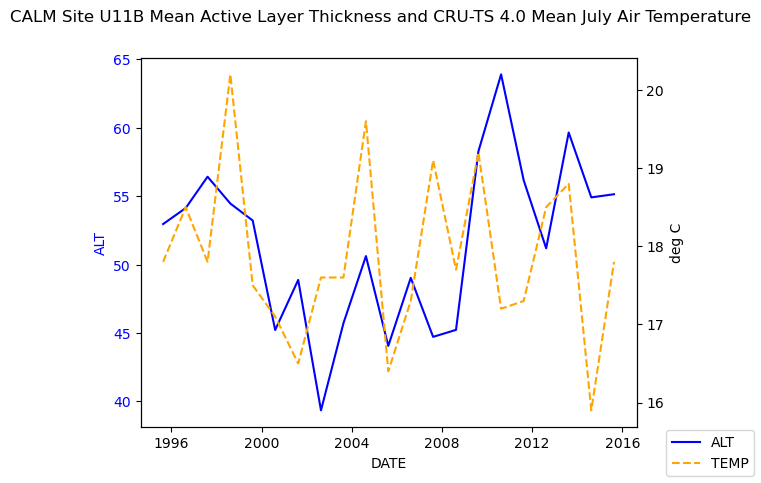

In [23]:
#plot the data to explore relationships

x = alt_data_1995_2015['DATE']
y1 = alt_data_1995_2015['MEAN_ALT_CM'].astype(float)
y2 = alt_data_1995_2015['MAX_JULY_TEMP'].astype(float)

fig, ax1 = plt.subplots()

ax1.set_xlabel('DATE')
ax1.set_ylabel('ALT', color='blue')
ax1.plot(x, y1, color='blue', label='ALT')
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx() 
ax2.set_ylabel('deg C')
ax2.plot(x, y2, color='orange', label="TEMP", linestyle='dashed')
ax2.tick_params(axis='y')

#fig.tight_layout()
fig.legend(loc='lower right')
fig.suptitle("CALM Site U11B Mean Active Layer Thickness and CRU-TS 4.0 Mean July Air Temperature")
plt.show()